## Imports

Make sure you append the correct path to where the folder containing the packages are located.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mypackages.edp_processing import ImageAnalysis, ImageProcessing, peak_calibration

## Loading the data

There is a variety of ways of loading the data into the scripts, here we opt to import the images as .tif using the ImageProcessing class. The only requirement is that the data is loaded as numpy arrays of 16 bit datatype. 

Tiff images

In [3]:
directory = r"Z:\ActualWork\Victor\F30\au\20250723\tif\test_au.1.tif"
processing = ImageProcessing(directory)
img = processing.load_images(1)

: 

Load .ser data

In [2]:
import hyperspy.api as hs

directory = r"E:\data_processing\data\raw\ED\In2O3"
names = [x for x in os.listdir(directory) if x.endswith('.ser')] 

file_path = os.path.join(directory, names[0])
data = hs.load(file_path, signal_type='diffraction', lazy=True)
imgs = np.array(data)
img= imgs.sum(axis=0)
del imgs

WARNING | Hyperspy | `signal_type='diffraction'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:745)


Load .dm4 data

In [8]:
import dm4

# --- Define file paths ---
input_path = "/home/ABTLUS/victor.secco/data_processing/ED/MnO/F-MnO-ODE-S2-PDF_2.dm4"
npy_output_path = "/home/ABTLUS/victor.secco/data_processing/ED/MnO/F-MnO-ODE-S2-PDF_2.npy"
tif_output_path = "/home/ABTLUS/victor.secco/data_processing/ED/MnO/F-MnO-ODE-S2-PDF_2.tif"

# --- Open .dm4 file and extract image data ---
with dm4.DM4File.open(input_path) as dm4file:
    tags = dm4file.read_directory()

    image_data_tag = tags.named_subdirs['ImageList'].unnamed_subdirs[1].named_subdirs['ImageData']
    image_tag = image_data_tag.named_tags['Data']

    XDim = dm4file.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[0])
    YDim = dm4file.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[1])

    image_array = np.array(dm4file.read_tag_data(image_tag), dtype=np.float64)
    image_array = np.reshape(image_array, (YDim, XDim))

## Finding the center of the diffraction pattern

The find_center function uses the Hough circle transform and edge detection methods to locate the center of the diffraction pattern. The remainder of the cell plots the identified circle.

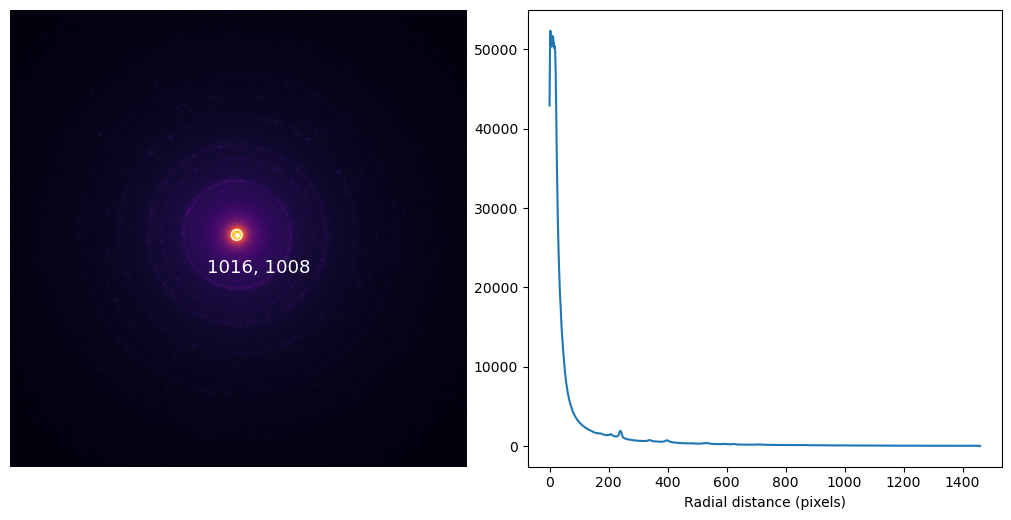

In [38]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

masking = False
side = False
b = 2

analysis = ImageAnalysis()

def pad_image_for_hough(image, pad_width=512, mode='constant'):
    padded_image = np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode=mode)
    return padded_image, pad_width

# Apply padding

offset = 0
if side:
    img_padded, offset = pad_image_for_hough(img, pad_width=512)

center_x, center_y, r, thre, blur, edges = analysis.find_center(
    img,
    r=1,                 # Smallest radius
    R=5000,              # Largest radius
    threshold=150,        # Threshold for diffractogram
    edges_thresh1=255,   # Canny edge detector threshold 1
    edges_thresh2=10     # Canny edge detector threshold 2
)

#center_x -= offset
#center_y -= offset

circle1 = Circle((center_x+offset, center_y+offset), r, fill=False, color='white')

if masking:
    beamstop_mask = processing.load_mask(r"E:\data_processing\data\processed\epdf\MASKS\spirit_mask.tif")
    if b == 1 or beamstop_mask.shape[0]==2048:
        img[beamstop_mask == 255] = 0
    elif beamstop_mask.shape[0]==4096:
        def bin_2d_by_2(arr):
            shape = arr.shape
            assert shape[0] % 2 == 0 and shape[1] % 2 == 0

            return arr.reshape(shape[0]//2, 2, shape[1]//2, 2).mean(axis=(1, 3))

        binned_mask = bin_2d_by_2(beamstop_mask)
        img[binned_mask == 255] = 0

    # defects_mask = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/ED/MASKS/test_defects_mask.png')
    # img[defects_mask == 255] = 0

if b==4:
    binning = 1024
else:
    binning = 1460

data, polar_image, _ = analysis.azimuth_integration_cv2(img, center=[center_x, center_y], binning=binning)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img**(1/2), cmap='inferno')
ax[0].scatter(center_x+offset, center_y+offset, s=5, color='white')
ax[0].add_patch(circle1)
ax[0].axis('off')
ax[0].text(center_x + offset + 100, center_y + offset + 150,
           f'{center_x:.0f}, {center_y:.0f}',  # format as float with 2 decimal places
           color='white', fontsize=13, ha='center', va='center')



ax[1].plot(data)
ax[1].set_xlabel('Radial distance (pixels)')

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout(pad=0)


## Optional: Testing the precision of the identified center

We can verify the symmetry of the identified center by averaging azimuthally in both the x and y directions. If the position of the peaks are aligned, the center is correct.

In [40]:
#Tune the binning of the averaging to the furthest distance to the border of the diffraction


ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(1024, center_x, center_y)

res1 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(325, 305), method = "ocl_lut_integr")
res2 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(125, 145), method = "ocl_lut_integr")
res3 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(80, 100), method = "ocl_lut_integr")
res4 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(-80, -100), method = "ocl_lut_integr")

plot_range = int(0.33*binning)

fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].set_title('Integração em x')
ax[0].plot(res1[1][0:plot_range])
ax[0].plot(res2[1][0:plot_range])

ax[1].set_title('Integração em y')
ax[1].plot(res3[1][0:plot_range])
ax[1].plot(res4[1][0:plot_range])

plt.tight_layout()
plt.show()

NameError: name 'pyFAI' is not defined

## Azimuthal average and saving

Plotting and saving the intensity of the azimuthally averaged diffraction. The x-axis is not saved as it is not 

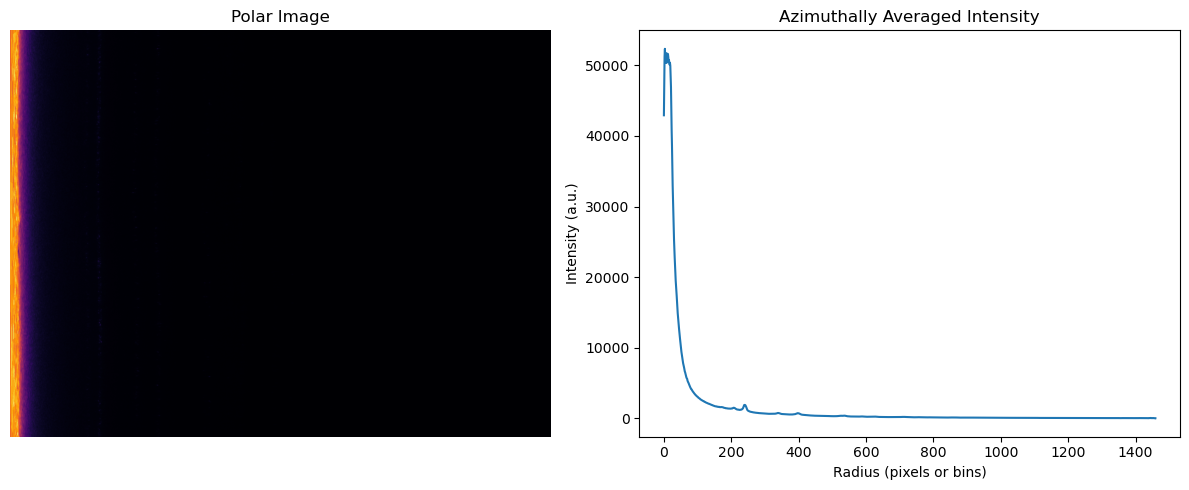

In [39]:
import matplotlib.pyplot as plt

# --- Mask the beamstopper and defects ---
processing = ImageProcessing(directory)

# Apply beamstopper mask
#mask = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/ED/MASKS/mask_titan.tif')
#img[mask == 255] = -100

# Apply defects mask
#mask = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/ED/MASKS/test_defects_mask.png')
#img[mask == 255] = -100

# --- Perform azimuthal integration ---
data, polar_image, _ = analysis.azimuth_integration_cv2(
    img,
    center=[center_x, center_y],
    binning=binning
)

# --- Plot polar image and integrated intensity ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Left: polar transformation
ax[0].imshow(polar_image, cmap='inferno', aspect='auto')
ax[0].set_title("Polar Image")
ax[0].axis('off')

# Right: 1D intensity plot
ax[1].plot(data)
ax[1].set_title("Azimuthally Averaged Intensity")
ax[1].set_xlabel("Radius (pixels or bins)")
ax[1].set_ylabel("Intensity (a.u.)")

plt.tight_layout()
plt.show()


In [40]:
import pandas as pd

save_path = r"C:\Users\seccolev\data_processing\data\processed\ePDF\Au\saturation\cds"

#q = np.linspace(0, len(data)*0.00743649587727647, len(data))
roi = pd.DataFrame(np.array([data]).T)
roi.to_csv(os.path.join(save_path,("200ms.csv")), index = None, sep = "\t")

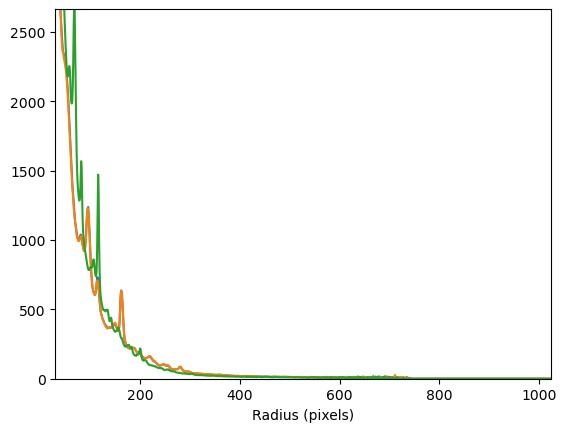

In [55]:
flat = pd.read_csv(os.path.join(save_path,("F-Fe3O4-E-A-s6-4.csv")), sep = "\t", header = None)
wob = pd.read_csv(os.path.join(save_path,("F-Fe3O4-E-A-s6-3.csv")), sep = "\t", header = None)
flat2 = pd.read_csv(os.path.join(save_path,("F-Fe3O4-E-A-s6-5.csv")), sep = "\t", header = None)

plt.plot(flat[0], label = "Flat")
plt.plot(wob[0], label = "Wobble")
plt.plot(flat2[0], label = "Flat2")
plt.xlabel("Radius (pixels)")
plt.xlim(30, 1024)
plt.ylim(0, 0.05 * np.max(flat[0]))

summed = flat[0] + wob[0]
summed.to_csv(os.path.join(save_path,("F-Fe3O4-E-A-s6_summed.csv")), index = None, sep = "\t")

In [41]:
import os
import re
import tifffile as tiff  # or: from imageio import imread

paths = {
    "cds": r"Z:\ActualWork\Victor\Au\beam saturation\cds",
    "rolling_shutter": r"Z:\ActualWork\Victor\Au\beam saturation\rolling_shutter"
}

maxes = {}

for key, folder in paths.items():
    files = [f for f in os.listdir(folder) if f.lower().endswith(".tif")]
    files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

    file_maxes = []
    for f in files:
        img = tiff.imread(os.path.join(folder, f))  # or imread(...) if using imageio
        file_maxes.append((f, img.max()))

    maxes[key] = file_maxes


In [28]:
img.max()

np.uint16(65535)

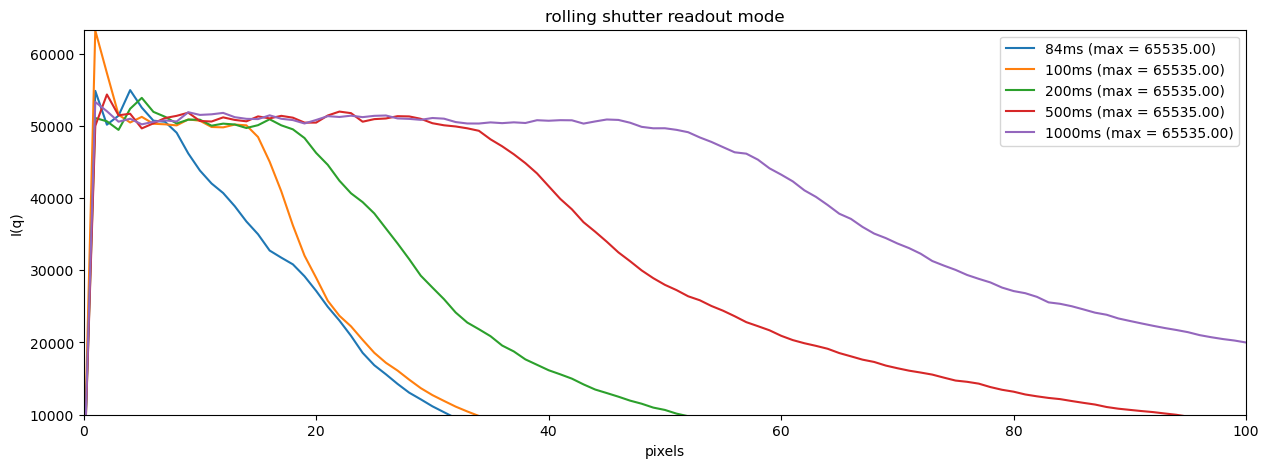

In [54]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff

# Base folders
data_folder = r"C:\Users\seccolev\data_processing\data\processed\ePDF\Au\saturation"
tif_folder = r"Z:\ActualWork\Victor\Au\beam saturation\rolling_shutter"

plt.figure(figsize=(15, 5))

# Get and sort csv filenames by numeric exposure time
names = [x for x in os.listdir(data_folder) if x.endswith('.csv')]
names.sort(key=lambda x: int(re.search(r'\d+', x).group()))

for i in names:
    # Read CSV
    df = pd.read_csv(os.path.join(data_folder, i), sep="\t", header=None)

    # Match corresponding .tif image (same name but with .tif extension)
    tif_name = i.replace(".csv", ".tif")
    tif_path = os.path.join(tif_folder, tif_name)

    # Read and get max from tif image
    if os.path.exists(tif_path):
        img = tiff.imread(tif_path)
        max_val = img.max()
    else:
        max_val = float('nan')  # or you could raise a warning or print a message

    # Plot with tif max value in legend
    label = f"{i[:-4]} (max = {max_val:.2f})"
    plt.plot(df[0], label=label)

plt.xlim(0, 100)
plt.ylim(10000, np.max(df[0])+10000)
plt.title("rolling shutter readout mode")
plt.xlabel("pixels")
plt.ylabel("I(q)")
plt.legend()
plt.show()


In [12]:
names

['1000ms.csv', '100ms.csv', '20ms.csv', '500ms.csv', '50ms.csv']

In [ ]:
import subprocess
import os

# --- Define working path and filenames ---
main_directory = '/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/W2/'
prepare_macro = 'prepare.mac'
file_names = [
    'CdSe_W2.iqobs',
    # Add more filenames here
]

# --- Step 1: Run prepare.mac (macro file name only, full path in argument) ---
prepare_commands = (
    'cd ..\n'
    'cd ..\n'
    'cd ..\n'
    f'@{prepare_macro} ED/CdSe_ePDF/W2/CdSe_W2\n'
)

process = subprocess.Popen(
    ['discus_suite'],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

stdout_prepare, stderr_prepare = process.communicate(input=prepare_commands)

print("Output from prepare.mac:")
print(stdout_prepare)
print("Errors from prepare.mac:")
print(stderr_prepare)

# --- Step 2: Process .iqobs files with exp2pdf.mac ---
exp2pdf_commands = (
    'cd ..\n'
    'cd ..\n'
    'cd ..\n'
)

for file in file_names:
    base_name = file[:-6] if file.endswith('.iqobs') else file
    full_input_path = f'ED/CdSe_ePDF/W2/{base_name}'
    exp2pdf_commands += f'@exp2pdf.mac ac, 1.0, {full_input_path}\n'

process = subprocess.Popen(
    ['discus_suite'],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

stdout_exp2pdf, stderr_exp2pdf = process.communicate(input=exp2pdf_commands)

print("Output from exp2pdf.mac:")
print(stdout_exp2pdf)
print("Errors from exp2pdf.mac:")
print(stderr_exp2pdf)


In [ ]:

from mypackages.eRDF import butter_lowpass_filter,DataProcessor, read_discus_fit_file

df=read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/W2/CdSe_W2_tests_1.00.fqobs')
df1=read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/W2/CdSe_W2_1.00.fqobs')

plt.plot(df1['r'].values, df1['gr'].values)
plt.plot(df['r'].values, df['gr'].values+5)

plt.xlim(1,20)
